# Group 42 Project - Tennis Prize Predictions

## Introduction

The Association of Tennis Professionals (ATP) circuit is for the best male tennis players in the world. The better players perform in each ATP tournament, the more points they accumulate, and the higher the players are ranked. Additionally, for each round that a player wins, they earn prize money. The player who wins the tournament receives the most points and prize money, which can vary based on the tournament level. 

Therefore, based on factors such as current ranking, points accumulated, and best ranking, which variable affects a player's prize money the most?  

To do so, we are using the dataset: player_stats, sourced from  https://www.ultimatetennisstatistics.com/ and containing statistical information for the current top 500 tennis players in the ATP. It reports on factors such as handedness and age, although many columns are missing data for a lot of players.


## Methods

Given that we intended to predict numerical values (prize money), we performed a linear regression analysis.

According to Schneider et al. (2010), regression analysis allows us to identify and characterise relationships between multiple factors.  It enables three important characteristics: a description of the relationship, an estimation of the dependent variable, and a prognostication of an individual point. Linear regression, a specific form of regression, is used to study the linear relationship between a dependent variable and one or more independent variables. The dependent variable must be continuous (i.e. quantitative), but the independent variable can be continuous or categorical. 

First, we loaded the dataset into R, as sourced from Ultimate Tennis Statistics. Then, we tidied the data, which included separating some columns into multiple columns, removing columns and rows that we did not feel would be valuable to our analysis, and otherwise adjusting the formatting and types of the data to suit our needs, such as creating a log_prize_money column. Then, we split our tidied dataset into training and testing data, and used the training data to perform preliminary data analysis. Since we are analysing how multiple variables affect a single dependent variable, we are performing multivariable linear regression (Schneider et al., 2010). This preliminary analysis included generating a table with the means, modes, and number of rows with missing data for each predictor variable as well as prize_money and log_prize_money. We also created visualizations for our preliminary data analysis that showed how each predictor variable interacted with log_prize money. In linear regression, the initial visualisation of the relationships must be on a scatter plot (Schneider et al., 2010), which is what we created. Next, we performed our linear regression by creating a model and recipe, then running them through a workflow with our training data. This yielded a regression model that we then used to generate predictions based on the training data,  allowing us to compare the predicted values with the actual values for log_prize_money. Then, we used our model to generate predictions based on the testing data. Finally, to visualize the effectiveness of our linear regression model, we generated scatter plot graphs similar to those in our preliminary data visualizations, but using layering in ggplot() to show the predictions. Based on these graphs, we generated a final graph that showed a single scatter graph with a linear regression line of our predicted variable that had the strongest relationship with prize money. 



## Data Analysis 

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
install.packages("GGally")
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

#### Demonstrate that the dataset can be read from the web into R

In [3]:
tennis_data <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Clean and wrangle data into a tidy format

In [4]:
names(tennis_data)[names(tennis_data) == 'Prize Money'] <- 'prize_money'#renames Prize Money column to prize_money
tidy_tennis <- tennis_data |>
    select(Age:Plays,("Current Rank"):prize_money)|> #Removes columns with high proportions of NA 
    separate(col=Age,into=c("age","birth_date"),sep=" ")|> #Separates age and birth date into seperate columns
    separate(col=("Current Rank"),into=c("current_rank","points"),sep=" ")|> 
        #Separates current rank and points into separate columns)
    separate(col=("Best Rank"),into=c("best_rank", "best_rank_date"),sep=" ")|> 
        #Separates best rank and date of best rank into separate columns
    mutate(birth_date= gsub("[()]","",birth_date)) |> #Removes brackets
    mutate(points= gsub("[()]", "", points)) |> #Removes brackets
    mutate(best_rank_date=gsub("[()]","",best_rank_date))|> #Removes brackets
    mutate(birth_date=as_date(birth_date, format='%d-%m-%Y')) |> #Converts birth_date column to date objects
    mutate(best_rank_date=as_date(best_rank_date, format='%d-%m-%Y')) |> #Converts best_rank_date column to date objects
    mutate(age=as.numeric(age)) |> #Converts age column to numberic objects
    mutate(current_rank=as.numeric(current_rank)) |> #Converts current_rank column to numberic objects
    mutate(points=as.numeric(points)) |> #Converts points column to numberic objects
    mutate(best_rank=as.numeric(best_rank))|> #Converts best_rank column to numberic objects
    mutate(prize_money=gsub("[US$,]","",prize_money))|> #Removes some of the non-numeric aspects of prize_money data
    separate(col=prize_money,into=c("prize_money","x"),sep=". ") |> 
        #removes the remaining non-numeric aspects of prize_money data
    select(age:prize_money) |> #removes unnecessary x column, which contained removed non-numeric aspects of prize-money data
    mutate(prize_money=as.numeric(prize_money))|>#converts prize_money column to numeric objects
    mutate(log_prize_money=log(prize_money)) |>#creates log_prize_money column
    drop_na(age)#removes anomalous row in which all values were NA
tidy_tennis<-as.data.frame(tidy_tennis)
tidy_tennis <- tidy_tennis |>
    mutate(best_age=difftime(best_rank_date, birth_date, units="weeks")) |> #determined best age in weeks
    mutate(best_age=best_age/52) |> #determined best age in years
    separate(col=best_age,into=c("best_age","x"),sep="\t") |>#adjusted format to remove "weeks"
    mutate(best_age=as.numeric(best_age))
tidy_tennis <- tidy_tennis %>% mutate(best_age=floor(best_age))
tidy_tennis <- tidy_tennis |>
    select(age, Country, current_rank:best_rank, log_prize_money, best_age) 
slice(tidy_tennis, 1:3)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 20 rows [16, 96, 128, 142,
208, 212, 267, 274, 337, 363, 364, 381, 394, 414, 423, 435, 436, 461, 468,
497].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 397 rows [2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 499 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


age,Country,current_rank,points,best_rank,log_prize_money,best_age
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26,Brazil,378,97,363,NA,26
18,United Kingdom,326,119,316,10.98597,17
32,Slovakia,178,280,44,14.99772,25


Table 1: Tidy Tennis Data

#### Using only training data, summarize the data in at least one table (this is exploratory data analysis).

In [5]:
set.seed(1111)#allows for reproducible randomness in data
tennis_split <- initial_split(tidy_tennis, prop = 0.75, strata = log_prize_money)#split data into training and testing sets
tennis_training <- training(tennis_split)#pulled training data
tennis_testing <- testing(tennis_split)#pulled testing data
tennis_list <- list(Column=c("age","Country","current_rank",
                             "points","best_rank","prize_money", "log_prize_money", "best_age"),
                    Approximate_Mean=c(26,"NA",247,462,175,2049631, 13, 24),
                    Mode=c(24,"France","NA",69,78,"NA","NA", 26),
                    Rows_with_Missing_Data=c(0,0,3,3,0,58, 58, 0)) 
tennis_summary <- data.frame(tennis_list) 
    #Created summary dataframe using values obtained through analysis steps which have not been included
tennis_summary

Column,Approximate_Mean,Mode,Rows_with_Missing_Data
<chr>,<chr>,<chr>,<dbl>
age,26,24,0
Country,NA,France,0
current_rank,247,NA,3
points,462,69,3
best_rank,175,78,0
prize_money,2049631,NA,58
log_prize_money,13,NA,58
best_age,24,26,0


Table 2: Summary of Tennis Data

#### Remove Missing Data 

In [6]:
tennis_training <- na.omit(tennis_training) 
tennis_testing <- na.omit(tennis_testing)

#### Figure 1: Preliminary Data Visualization 

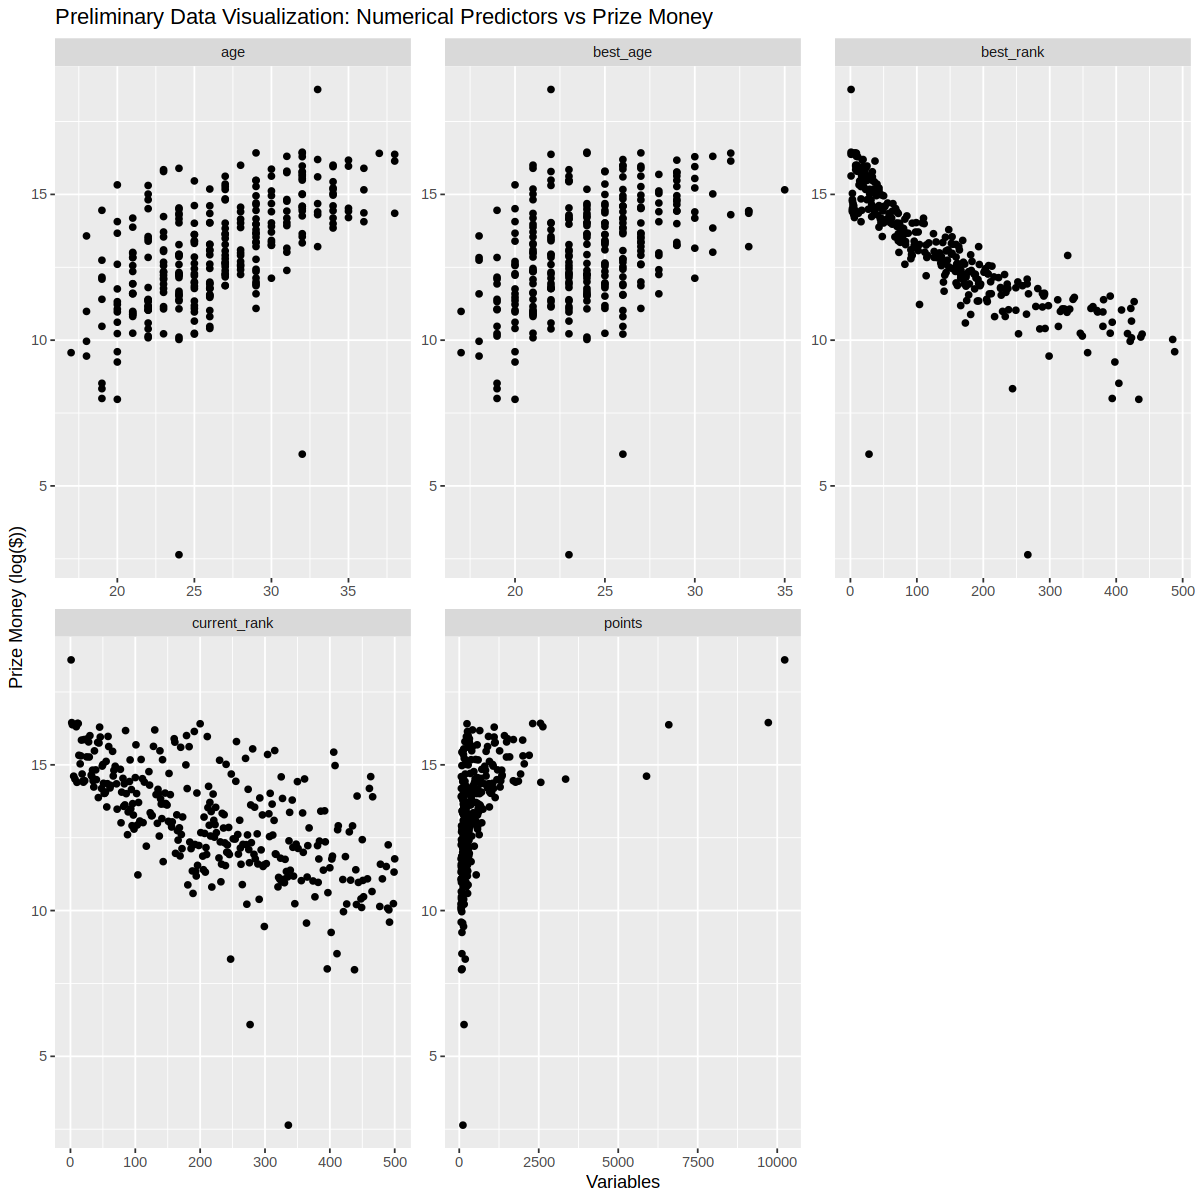

In [7]:
options(repr.plot.height=10, repr.plot.width=10)
#Preliminary data visualization plot
tennis.gathered <- tennis_training %>%
  as.data.frame() %>%
  gather(key = "variable", value = "value",
         -log_prize_money, -Country)
ggplot(tennis.gathered, aes(x = value, y = log_prize_money)) +
    labs(x = "Variables", y = 'Prize Money (log($))')+
    ggtitle("Preliminary Data Visualization: Numerical Predictors vs Prize Money")+
     geom_point() +
  facet_wrap(~variable, scales="free" )

#### Perform Data Analysis (Linear Regression)

In [8]:
set.seed(1111)#allows for reproducible randomness in data
lm_spec <- linear_reg() |>
    set_engine('lm') |>
    set_mode("regression") 

lm_recipe <- recipe(log_prize_money ~age+Country+current_rank+points+best_rank+best_age , data = tennis_training)

lm_fit <- workflow () |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec)|>
    fit(tennis_training)

lm_tennis_train_results <- lm_fit |>
    predict(tennis_training) |>
    bind_cols(tennis_training) |>
    metrics(truth = log_prize_money, estimate = .pred)

lm_predict = lm_fit |>
    predict(tennis_training) |>
    bind_cols(tennis_training)

lm_tennis_test_results<- lm_fit |>
    predict(tennis_testing) |>
    bind_cols(tennis_testing) |>
    metrics(truth = log_prize_money, estimate = .pred)

mcoeffs <- lm_fit |>
    extract_fit_parsnip() |>
    tidy()


#### Figure 2: Visualization of the Analysis

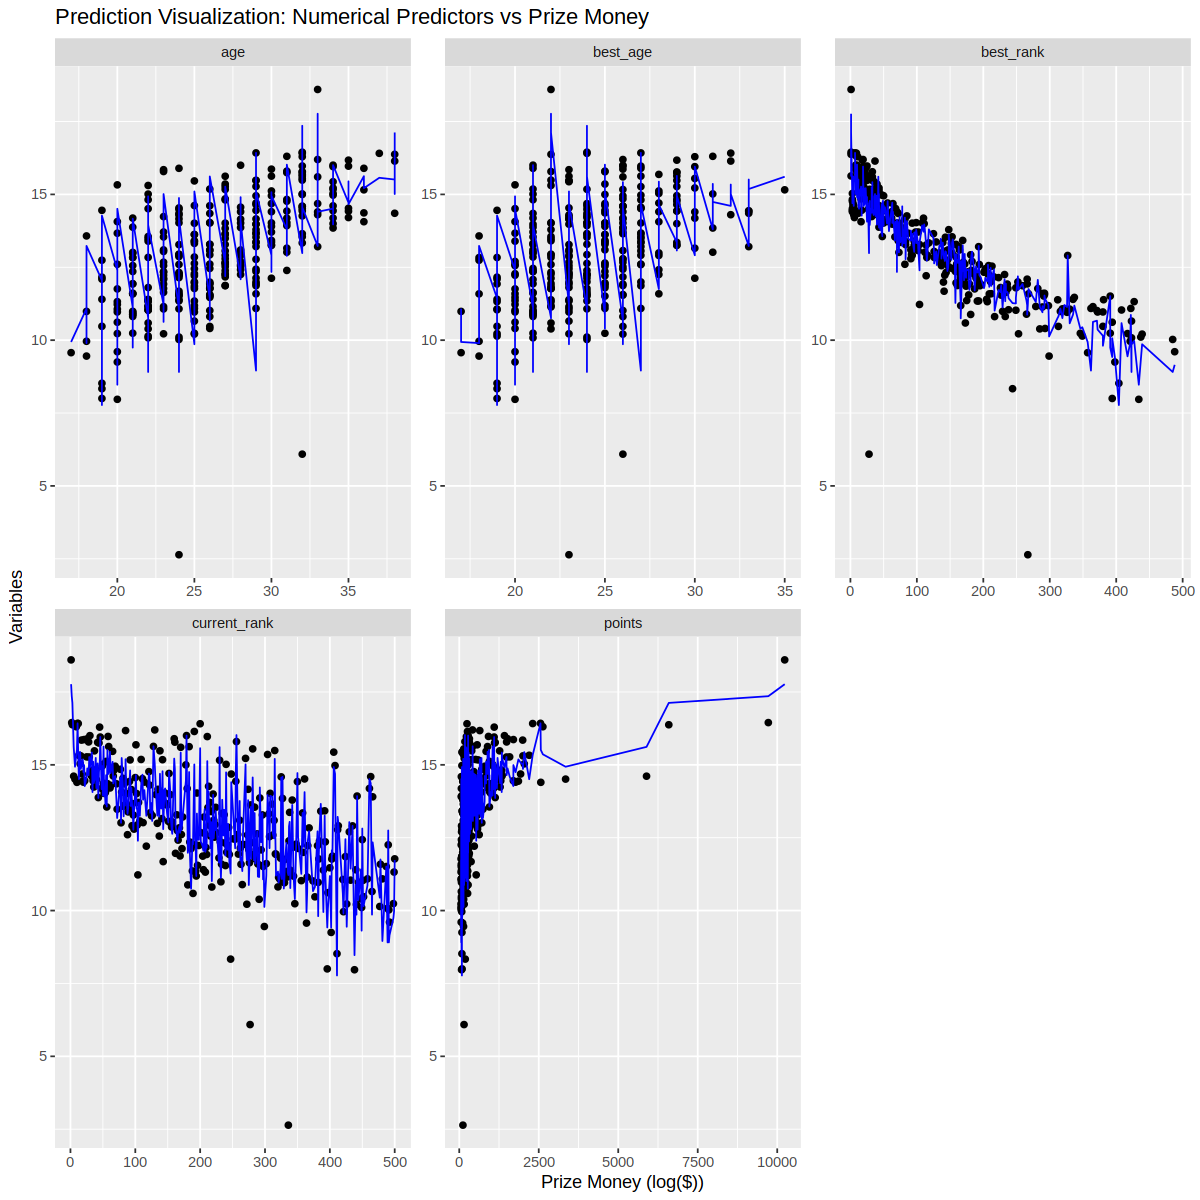

In [10]:
options(repr.plot.height=10, repr.plot.width=10)
tennis_predict_gathered <- lm_predict %>%
  as.data.frame() %>%
  gather(key = "variable", value = "value",
         -log_prize_money, -Country, -.pred)
ggplot(tennis_predict_gathered, aes(x = value, y = log_prize_money)) +
    ggtitle("Prediction Visualization: Numerical Predictors vs Prize Money")+
  geom_point() +
    labs(x = "Prize Money (log($))", y = "Variables")+
    geom_line(mapping=aes(x=value, y=.pred), color="blue")+
  facet_wrap(~variable, scales="free" )

#### Figure 3: Visualization of our prediction 

`geom_smooth()` using formula = 'y ~ x'


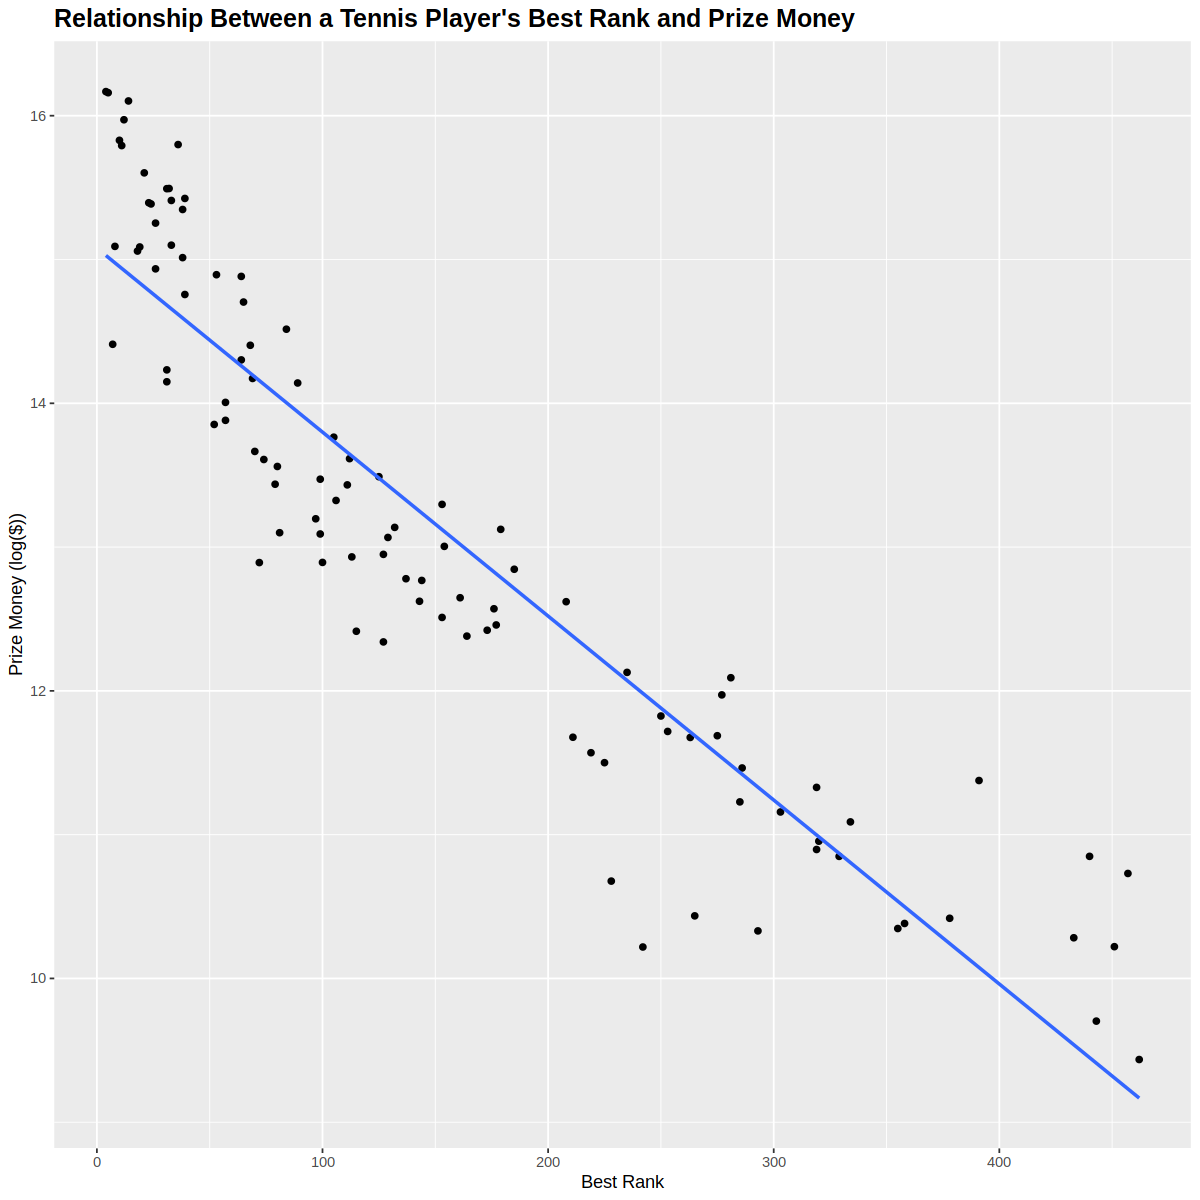

In [11]:
#Visualise the Linear Regression (superimpose predicted line on original data)
# Relationship between best_rank and log_prize_money, and the regression line
lm_plot_rank <- ggplot(tennis_testing, aes(x=best_rank, y=log_prize_money)) + 
    geom_point() +
    xlab("Best Rank") +
    ylab("Prize Money (log($))")+
    ggtitle("Relationship Between a Tennis Player's Best Rank and Prize Money")+ 
    geom_smooth(method="lm", se=FALSE) +
    theme(plot.title = element_text(size = 15, face = "bold")) 
options(repr.plot.height=10, repr.plot.width=10)

lm_plot_rank

### Results

In [12]:
#state results
lm_tennis_train_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.8792128
rsq,standard,0.7880720
mae,standard,0.5212490


Table 3: Training Data Results

In [13]:
lm_tennis_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.6850979
rsq,standard,0.8548340
mae,standard,0.5504905


Table 4: Test Data Results

In [14]:
# Most important variables in regression
mcoeffs_sort <- mcoeffs[order(-mcoeffs$estimate),] 
head(mcoeffs_sort,20)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),12.4924970,0.6222770,20.0754593,4.815318e-54
CountryMonaco,2.1446866,1.0380483,2.0660758,3.985161e-02
CountryZimbabwe,1.5675721,1.0380553,1.5101046,1.322796e-01
CountryBelgium,1.3850458,1.0316691,1.3425292,1.806422e-01
CountryLatvia,1.3590926,0.7528042,1.8053734,7.221925e-02
CountryTunisia,1.0957663,0.7581162,1.4453805,1.496034e-01
CountryUruguay,1.0197565,1.0303031,0.9897636,3.232467e-01
CountryCyprus,0.9045288,1.0560204,0.8565449,3.925167e-01
CountryRomania,0.8451364,0.7516585,1.1243621,2.619378e-01


Table 5: Variable Coefficients 

In [15]:
rank_coef <- mcoeffs |> filter(term=="best_rank") 
rank_coef

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
best_rank,-0.01107754,0.001057966,-10.4706,1.646812e-21


Table 6: Rank Coefficient 

## Discussion

We performed a linear regression analysis on an ATP tennis player’s prize money based on their age, country, current rank, points, best rank, and the age when they obtained their best rank. 

Based on our findings, a tennis player’s best rank has the largest influence of prize money. 

These results were expected based on our preliminary data analysis. When we generated visualisations on our preliminary data (Figure 1), it can also be seen that best_rank appeared to have the strongest correlation to prize money as the data points were the closest together and closely resembled a linear trend. While we also speculated that age may play a role in prize money, the data points were not as close to the regression line, thus indicating that the relationship was not as strong.

When we analyzed the data by performing linear regression, our findings were shown in Figure 2, which visualized our linear regression model. Based on the individual scatter plots generated for each chosen variable, it can be seen that the best_rank variable has the strongest correlation to prize money as the points were the closest to the regression line, and it appears to have the most linear correlation. When further analysed, in comparison to age which is a close contestant, it can be seen that the best rank had the strongest linear correlation as the data points were closest to the linear regression line. When looked at closer, Figure 3 shows a negative relationship between prize money and best rank. This means the larger your ranking number is (meaning you are ranked lower), the lower your prize money is. However, this actually correlates to a positive correlation because the higher your ranking is (ie. smaller the number), the higher your prize money.

These finding are further supported first by the rmse value generated when comparing the training dataset with actual values. Table 4 shows that our rmse was 0.6850979, meaning that the prediction is approximately 0.69 units off the actual value. Considering that the range of values for log_prize_money is from about 0 to 20, we would expect an rmse of 0 to mean that the model predicts the data perfectly, and 0.69 units is adequate. 

These findings  support previous literature on tennis players’ prize money. Being a professional tennis player is not cheap as there are many expenses players must account for such as travel costs, coaching, and tennis gear. As such, Govea et al. (2022) found that only the 100 best-ranked tennis players can cover their cost. This is because they must be ranked high enough to enter the most lucrative tournaments where they can earn that money. The top ten ranked tennis players are able to finance a team of high-level individuals who can support them permanently (Govea et al., 2022). 

Therefore, these findings further support how the tennis ranking system works. A higher a player’s rank, the better he is doing in tournaments, and thus the more prize money he is earning. Therefore, it is highly supported that ranking would have the strongest correlation to, and thus the highest impact on, prize money. Age is not as important as it can currently be seen that older players such as Novak Djokovic and Rafael Nadal are still earning high amounts of prize money.

As such, these findings further support the importance of high ranking in the ATP circuit. High rankings ensure that players are adequately able to finance themselves and their team. Previous studies have researched how prize money can be more fairly distributed, and these findings can help aid these investigations (Govea et al., 2022). Furthermore, these findings can help investors evaluate which tennis players they should invest in. Additionally, if a player has a predicted ranking trajectory, it can help sponsors decide which players they should be partnering with. 

Future studies can be performed to see potentially what factors most influence a player’s ranking. Other studies can investigate how to predict a player’s ranking trajectory based on several factors, and can analyse which factor plays the greatest role.


## References

Govea, Z., Pérez-Galarce, F., & Candia-Véjar, A. (2022). An optimization model for the fair distribution of prize money in ATP tournaments. International Journal of Computer Science in Sport, 21(1), 9–29. https://doi.org/10.2478/ijcss-2022-0002

Schneider, A., Hommel, G., & Blettner, M. (2010). Linear Regression analysis. Deutsches Arzteblatt International, 107(44), 776–782. https://doi.org/10.3238/arztebl.2010.0776

Ultimate Tennis Statistics. (n.d.). https://www.ultimatetennisstatistics.com/ 
